<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [32]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import shuffle
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from random import seed
from random import randint
from tensorflow import keras
from keras import layers, models, utils, datasets
from keras import utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, GridSearchCV
import time 
import concurrent.futures
import threading

#### Función para mostrar lista de imágenes en escala de grises

In [2]:
def show_row_of_gray_images(fig_width, *images):
    plt.figure(figsize=(fig_width, fig_width))
    images_count = len(images)
    index = 1  
    for image in images:
        plt.subplot(1, images_count, index)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        index+=1

In [3]:
IMG_SIZE = 32

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical")
])


#### Lectura de los datos:

In [16]:
def lectura_datos():
    # seed random number generator
    seed(1)

    # Dimensión de entrada de las imágenes 
    h = IMG_SIZE
    w = IMG_SIZE


    # Leer los nombres de las imágenes para importarlas
    input_class1_path = "./Dataset/Grading_dataset/Class_I"
    class1_names = os.listdir(input_class1_path)
    input_class2_path = "./Dataset/Grading_dataset/Class_II"
    class2_names = os.listdir(input_class2_path)
    input_classex_path = "./Dataset/Grading_dataset/Extra_Class"
    class3_names = os.listdir(input_classex_path)

    # Número de elementos en cada clase
    n = len(class1_names)


    # Definir listas para cargar imágenes
    class1 = np.ones([n, h, w, 3])
    class2 = np.ones([n, h, w, 3])
    class3 = np.ones([n, h, w, 3])



    for i in range(0, n, 1):
        # Para cada clase, se lee una imágen, se importa
        img = resize(imread("./Dataset/Grading_dataset/Class_I/" + class1_names[i]), (h, w))
        class1[i] = img  
        img = resize(imread("./Dataset/Grading_dataset/Class_II/" + class2_names[i]), (h, w))
        class2[i] = img 
        img = resize(imread("./Dataset/Grading_dataset/Extra_Class/" + class3_names[i]), (h, w))
        class3[i] = img
    
    return class1, class2, class3, n,h,w



#### Se muestran una imágen aleatoria de cada clase para comprobar que se leyeron correctamente

34


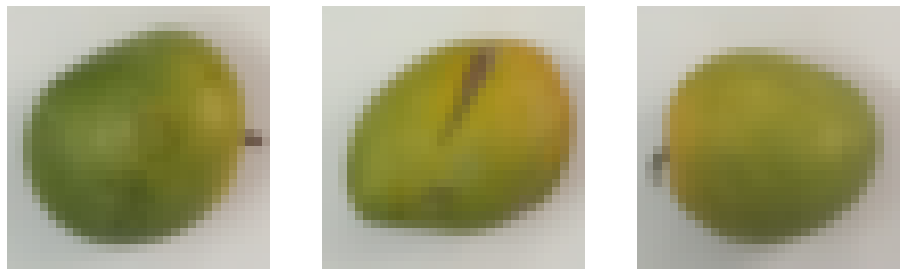

In [17]:
class1,class2,class3,n,h,w = lectura_datos()
rn = randint(0, 200)
print (rn)
img_1 = class1[rn]
img_2 = class2[rn]
img_3 = class3[rn]    
show_row_of_gray_images(16, img_1, img_2, img_3)

### Aumentamos por un factor f el número de datos de cada clase

In [21]:
def data_augmentations():
    f = 10
    class1_augmeted = np.zeros([n * f, h, w, 3])
    class2_augmeted = np.zeros([n * f, h, w, 3])
    class3_augmeted = np.zeros([n * f, h, w, 3])
    t1 = np.zeros(n * f)
    t2 = np.zeros(n * f)
    t3 = np.zeros(n * f)

    for i in range(n * f):
        rn = randint(0, n-1)
        img = class1[rn]
        new_img = data_augmentation(img)
        class1_augmeted [i] = new_img
        t1[i] = 1
        
        rn = randint(0, n-1)
        img = class2[rn]
        new_img = data_augmentation(img)
        class2_augmeted [i] = new_img
        t2[i] = 2
        
        rn = randint(0, n-1)
        img = class3[rn]
        new_img = data_augmentation(img)
        class3_augmeted [i] = new_img
        t3[i] = 3
    return t1,t2,t3,class1_augmeted,class2_augmeted,class3_augmeted,f

#### Se imprimen tres imágenes para comprobar que las transformaciones han salido bien

1585
540
34


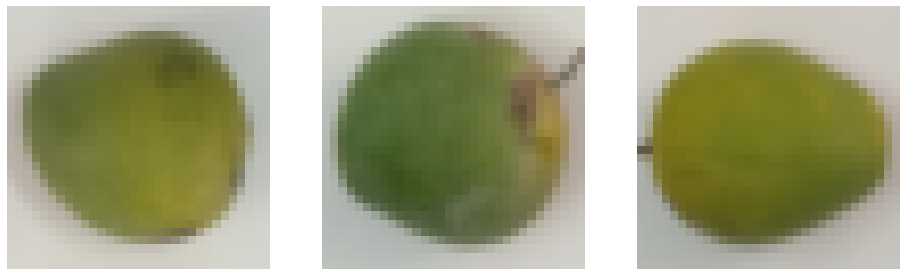

In [22]:
# Se imprimen tres imágenes aleatorias de los datos aumentados para comprobar que funciona    
t1,t2,t3,class1_augmeted,class2_augmeted,class3_augmeted,f = data_augmentations()
rn = randint(0, 2000)
img_1 = class1_augmeted[rn]
print (rn)
rn = randint(0, 2000)
print (rn)
img_2 = class2_augmeted[rn]
rn = randint(0, 2000)
print (rn)
img_3 = class3_augmeted[rn]  
show_row_of_gray_images(16, img_1, img_2, img_3)

#### Conformación del set de datos y declaración de las métricas de análsis:

In [23]:

# Se define el conjunto de datos de entrenamiento
X = np.zeros([(f-1)*n*3,h*w*3])
X[0:1800] = class3_augmeted[0:1800].reshape((f-1)*n,h*w*3)
X[1800:3600] = class1_augmeted[0:1800].reshape((f-1)*n,h*w*3)
X[3600:5400] = class2_augmeted[0:1800].reshape((f-1)*n,h*w*3)

# extract train and val features
X_train = np.ones([(f-1)*n*3,h,w,3])
X_train[0:1800] = class3_augmeted[0:1800]
X_train[1800:3600] = class1_augmeted[0:1800]
X_train[3600:5400] = class2_augmeted[0:1800]

# Se define el conjunto de datos de validación
X_val = np.zeros([n*3, h, w, 3])
X_val[0:200] = class3_augmeted[1800:2000]
X_val[200:400] = class1_augmeted[1800:2000]
X_val[400:600] = class2_augmeted[1800:2000]
# Se definen las etiquetas de las clases
t = np.zeros((f-1)*n*3)
t[0:1800] = t3[0:1800]
t[1800:3600] = t1[0:1800]
t[3600:5400] = t2[0:1800]
# Se definen las etiquetas de las clases para la validación
t_val = np.zeros(n*3)
t_val[0:200] = t3[1800:2000]
t_val[200:400] = t1[1800:2000]
t_val[400:600] = t2[1800:2000]

# Se definen el numero de folds, utilizando leaving one out 
kf = KFold(n_splits=5)
CV= kf.get_n_splits(X_train)

# Se definen las metricas para evaluar los diferentes modelos
scoring = ['recall_macro', 'precision_macro', 'f1_macro','accuracy','roc_auc_ovo']

#Gurdamos las variables 
%store scoring X X_train X_val CV t t_val f n 

Stored 'scoring' (list)
Stored 'X' (ndarray)
Stored 'X_train' (ndarray)
Stored 'X_val' (ndarray)
Stored 'CV' (int)
Stored 't' (ndarray)
Stored 't_val' (ndarray)
Stored 'f' (int)
Stored 'n' (int)


#### Analisis de tiempo de ejecución

In [30]:
#MULTI HILO

start = time.perf_counter()
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     executor.map(lectura_datos(),data_augmentations())
t1 = threading.Thread(target=lectura_datos())
t2 = threading.Thread(target=data_augmentations())
t1.start()
t2.start()
t1.join()
t2.join()
finish=time.perf_counter()


time_all_cores = finish-start





Text(0.5, 1.0, 'Comparación de tiempo de ejecución')

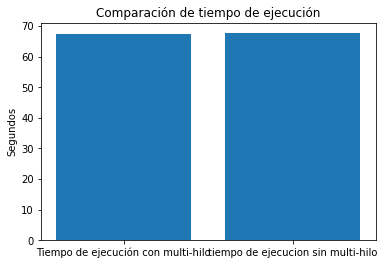

In [29]:
start = time.perf_counter()
data_augmentations()
lectura_datos()
finish=time.perf_counter()

time_one_core = finish-start
values = [time_all_cores,time_one_core]
labels = ["Tiempo de ejecución con multi-hilo","tiempo de ejecucion sin multi-hilo"]
p1 = plt.bar(labels,values)
plt.ylabel('Segundos')
plt.title('Comparación de tiempo de ejecución')
